In [27]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using GraphIO 
using ParserCombinator 
using PlotlyJS
using JLD2, DelimitedFiles

<h1>Table of Contents</h1>
<div>

<li><span><a href="#PolBlobgs" data-toc-modified-id="PolBlobgs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PolBlogs</a></span></li>
<li><span><a href="#Epinions" data-toc-modified-id="Epinions-1"><span class="toc-item-num">2&nbsp;&nbsp;</span>Epinions</a></span>
<ul class="toc-item"><li><span><a href="#MUNEpinions" data-toc-modified-id="MUNEpinions-1.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>MUN Epinions</a></li></ul>
<ul class="toc-item"><li><span><a href="#EROEpinions" data-toc-modified-id="EROEpinions-1.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>ERO Epinions</a></span></li><
</li>

<li><span><a href="#Stanford" data-toc-modified-id="Stanford-1"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stanford</a></span>
</div>

## 1. PolBlogs graph  <a id="PolBlogs"></a>

In [19]:
splg_methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS", # requires computing exact leverage scores
    "iid JL-LS",
    #"iid LS", # requires computing exact leverage scores
    "ST JL-LS",
    # "ST LS", # requires computing exact leverage scores
]

# simulation parameters
n_batch = 6; # maximum batch size considered
n_rep = 3; # number of runs

3

#### Laplacian spectrum

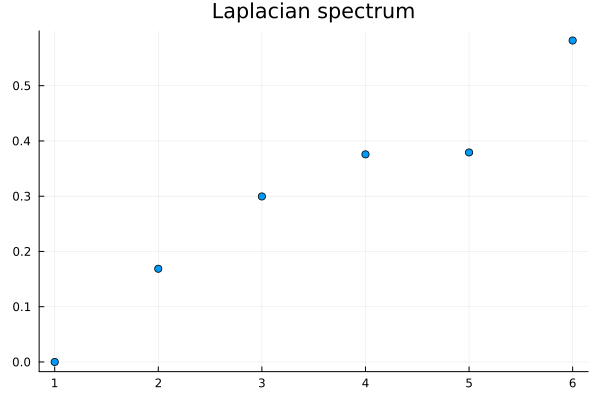

In [17]:
graph_name = "polblogs"
g = loadgraph("polblogs.gml", "digraph", GraphIO.GML.GMLFormat())
g = SimpleGraph(g)

rng = Random.default_rng()

# select largest connected component
temp = connected_components(g)
g = g[temp[1]]

meta_g = MetaGraph(g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

### plotting Laplacian spectrum

B = sp_magnetic_incidence(meta_g)
Lap = B' * B
Lap = 0.5 * (Lap + Lap')
least_eigs,_ = eigs(Lap; nev=6, which=:SM)

Plots.scatter(1:6,sort(real.(least_eigs));legend=false,title="Laplacian spectrum")

In [20]:
# regularization parameter
q = 0.01
# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)
# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "precond_"*graph_name*"_"*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 35205.57120411233
k = 

393 vs nb edges= 16717
 
k = 

393 vs nb edges= 16717
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

ST JL-LS

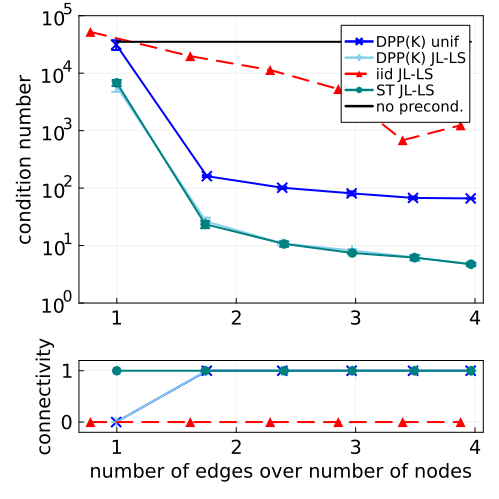

In [25]:
# loading results
q = 0.01
name = "precond_"*graph_name*"_"*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e5)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)
# saving plot
Plots.savefig("figures/"*name*".pdf")

## 2. Epinions  <a id="Epinions"></a>

#### loading Epinions

In [28]:
graph_name = "epinions"
list = readdlm("soc-Epinions1.txt")
mist = list .+ 1 # s.t. indices start at 1

list_tuple = Array(tuple.(eachcol(Int.(list))...))
e_list = Edge.(list_tuple)
meta_g = SimpleGraphFromIterator(e_list)

meta_g = main_component(meta_g)
meta_g = SimpleGraph(meta_g)
n = nv(meta_g)
m = ne(meta_g)
println("n= ",n)
println("m= ",m)

n= 75869
m= 405057


### 2.1 MUN Epinions <a id="MUNEpinions"></a>

In [29]:
type = "MUN"
rng = Random.default_rng()
eta = 0.05
planted_score = randperm(rng,n)
meta_g = turn_into_connection_graph(rng,meta_g,eta,type,planted_score)

{75869, 405057} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

### Computing sampling times

In [31]:
n_rep = 100
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up (precompilation)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

# storing settings
D_params = Dict("type" => type,"eta" => eta,"n_rep" =>  n_rep)
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

[0.61066701314 0.8322194010499999]


### plotting sampling times

In [32]:
eta = 0.05
q = 0
type = "MUN"
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)
PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/MUN_time_epinions_eta0.05q0.pdf"

### MUN Epinions precond

In [33]:
# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "MUN_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 500062.5434346616
method: DPP(K) unifmethod: 

ST unif

"MUN_precond_epinions_eta0.05q0"

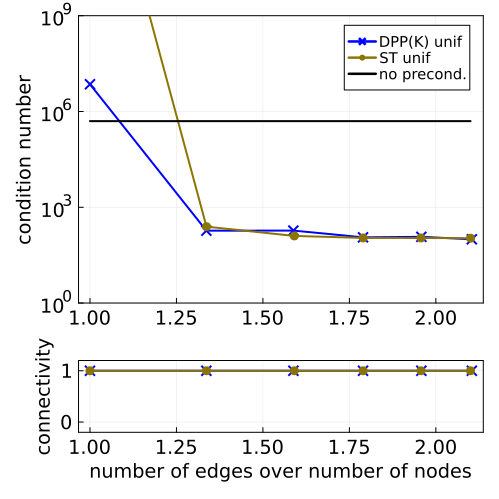

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/MUN_precond_epinions_eta0.05q0.pdf"

In [35]:
eta = 0.05
q = 0
name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
Plots.savefig("figures/"*name*".pdf")

### ERO Epinions

loading

In [36]:
type = "ERO"
rng = Random.default_rng()
eta = 2*1e-5
planted_score = randperm(rng,n)

meta_g = turn_into_connection_graph(rng,meta_g,eta,type,planted_score)

{75869, 405057} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [ ]:
# regularization parameter
q = 0.1
# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)
# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "precond_"*graph_name*"_"*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

### Computing sampling time

In [37]:
n_rep = 100
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

# storing settings
D_params = Dict("type" => type,"eta" => eta,"n_rep" =>  n_rep)
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

[0.95552061042 1.09063092836]


### Plotting sampling time

In [41]:
type = "ERO"
q = 0
eta = 2*1e-5
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

load("figures/data/"*name*"_data.jld2")

# cycle-rooted spanning forest
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning tree
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
plt_ERO =PlotlyJS.plot([trace_crsf, trace_st],layout)
PlotlyJS.savefig(plt_ERO,"figures/"*name*".pdf")

"figures/ERO_time_epinions_eta2.0e-5q0.pdf"

### ERO Epinions precond

In [39]:
# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 1.5540399605082255e7
method: DPP(K) unifmethod: 

ST unif

plotting

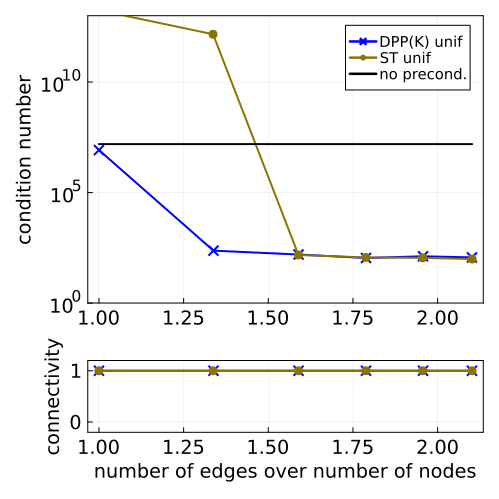

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/ERO_precond_epinions_eta2.0e-5q0.pdf"

In [50]:
eta = 2*1e-5
q = 0
type = "ERO"
name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

y_limits = (1,1e13)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
Plots.savefig("figures/"*name*".pdf")

### Pokec

In [108]:
graph_name = "pokec"
list = readdlm("soc-pokec-relationships.txt")
mist = list .+ 1 # s.t. indices start at 1

list_tuple = Array(tuple.(eachcol(Int.(list))...))
e_list = Edge.(list_tuple)
meta_g = SimpleGraphFromIterator(e_list)

meta_g = main_component(meta_g)
meta_g = SimpleGraph(meta_g)
n = nv(meta_g)
m = ne(meta_g)
println("n= ",n)
println("m= ",m)

n= 1632803
m= 22301964


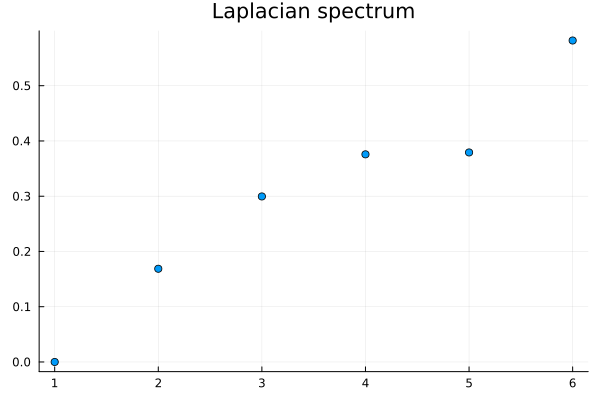

In [106]:
rng = Random.default_rng()

# select largest connected component

meta_g = MetaGraph(meta_g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

### plotting Laplacian spectrum

B = sp_magnetic_incidence(meta_g)
Lap = B' * B
Lap = 0.5 * (Lap + Lap')
least_eigs,_ = eigs(Lap; nev=6, which=:SM)

Plots.scatter(1:6,sort(real.(least_eigs));legend=false,title="Laplacian spectrum")

In [105]:
n_rep = 1
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0.2                    
absorbing_node = true
ust = true
weighted = false

# warm up (precompiling takes time)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

mean time CRSF sampling: 0.00459807
mean time ST sampling: 0.003611754


In [98]:
# regularization parameter

# simulation parameters
n_batch = 3 # maximum number of batches considered
n_rep = 1 # number of runs


splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]
q = 0.1
# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)
# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "precond_"*graph_name*"_"*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 3521.457120410904
method: DPP(K) unifmethod: 

ST unif

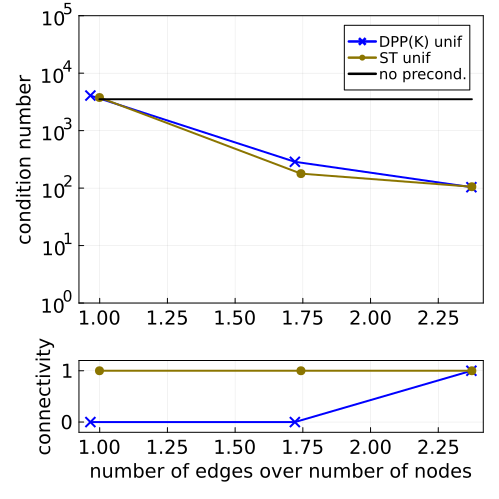

In [102]:
# loading results
q = 0.1
name = "precond_"*graph_name*"_"*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e5)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)
# saving plot
#Plots.savefig("figures/"*name*".pdf")

## 3. Stanford graph  <a id="Stanford"></a>

In [51]:
graph_name = "stanford"
list = readdlm("web-stanford.txt")

list_tuple = Array(tuple.(eachcol(Int.(list))...))
e_list = Edge.(list_tuple)
meta_g = SimpleGraphFromIterator(e_list)

# select largest connected component
meta_g = main_component(meta_g)
meta_g = SimpleGraph(meta_g)
n = nv(meta_g)
m = ne(meta_g)
println("Largest connected component")
println("n= ",n)
println("m= ",m)

Largest connected component
n= 255265
m= 1941926


In [83]:
type = "MUN"

# plant a noisy connection
rng = Random.default_rng()
eta = 0.01 # for MUN
planted_score = randperm(rng,n)

meta_g = turn_into_connection_graph(rng,meta_g,eta,type,planted_score)

{255265, 1941926} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [84]:
n_rep = 10
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up (precompiling takes time)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

mean time CRSF sampling: 12.3031206397
mean time ST sampling: 11.140512517500001


In [85]:
load("figures/data/"*name*"_data.jld2")
# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

plt_stanford = PlotlyJS.plot([trace_crsf, trace_st],layout)
PlotlyJS.savefig(plt_stanford,"figures/"*name*".pdf")


mean time CRSF sampling: 12.3031206397
mean time ST sampling: 11.140512517500001


"figures/MUN_time_stanford_eta0.01q0.pdf"

In [86]:
# simulation parameters
n_batch = 3 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)

name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 3.7041213281033707e8
method: DPP(K) unifmethod: 

ST unif

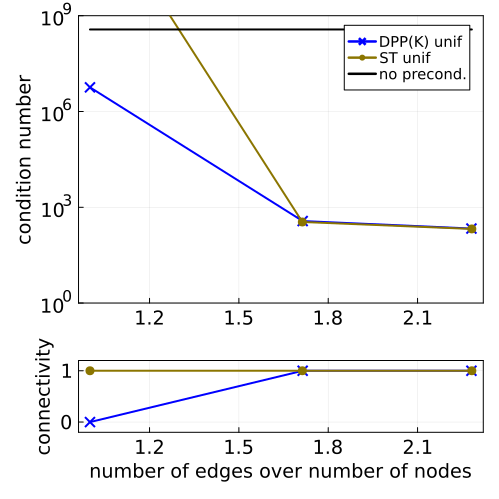

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/MUN_precond_stanford_eta0.01q0.pdf"

In [88]:
# plotting
name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)
# saving plot
Plots.savefig("figures/"*name*".pdf")

In [92]:
type = "ERO"

# plant a noisy connection
rng = Random.default_rng()
#eta = 0.05 # for MUN
eta = 1.0e-5
planted_score = randperm(rng,n)

meta_g = turn_into_connection_graph(rng,meta_g,eta,type,planted_score)

{255265, 1941926} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [93]:
n_rep = 10
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up (precompiling takes time)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

mean time CRSF sampling: 18.0518310012
mean time ST sampling: 17.2753315987


In [94]:
name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

load("figures/data/"*name*"_data.jld2")
# cycle-rooted spanning forests
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)

# spanning trees
trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
println("mean time CRSF sampling: ", mean(time_crsf))
println("mean time ST sampling: ",mean(time_st))

name = type*"_time_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)

plt_stanford = PlotlyJS.plot([trace_crsf, trace_st],layout)
PlotlyJS.savefig(plt_stanford,"figures/"*name*".pdf")


mean time CRSF sampling: 18.0518310012
mean time ST sampling: 17.2753315987


"figures/ERO_time_stanford_eta1.0e-5q0.pdf"

In [91]:
# simulation parameters
n_batch = 3 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)

name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 4.170032807383698e8
method: DPP(K) unifmethod: 

ST unif

InterruptException: InterruptException:

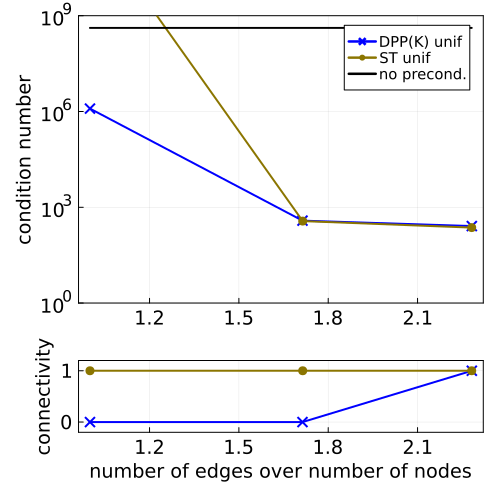

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/ERO_precond_stanford_eta1.0e-5q0.pdf"

In [71]:
# plotting
name = type*"_precond_"*graph_name*"_"*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)
# saving plot
Plots.savefig("figures/"*name*".pdf")